In [19]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from matplotlib.animation import FuncAnimation 


import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dotrain = True
dotest = True
doanim = True

epochs = 500
batch_size = 32

dense_numunits = 16
conv1d_numunits = 32
simplernn_numunits = 16
lstm_numunits = 16

history_length = 6
forecast_length = 24

np.random.seed(237)
tensorflow.random.set_seed(237)

In [20]:
def build_window(data, h, f):
    
    dataX, dataY = [], []
    
    for i in range(len(data)-h-f):
        dataX.append(data[i:(i+h)])
        dataY.append(data[(i+h):(i+h+f)])
        
    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    
    dataY = np.array(dataY)
    
    return dataX, dataY

# Load data

In [21]:
Y = pd.DataFrame()

folder = 'C:/Projects/Professional_Certificate_in_ML_and_AI/Module23/Notebooks_starter/traffic/'

prefix = '2018/flow_station_1209204_2018_'
for i in range(1,12):
    filename = '{}{}{:02d}'.format(folder,prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
prefix = '2019/flow_station_1209204_2019_'
for i in range(1,12):
    filename = '{}{}{:02d}'.format(folder,prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
raw_data = Y['Total Flow'].values
data = raw_data

C:\Users\Plamen\AppData\Local\Temp\ipykernel_26636\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_26636\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_26636\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_26636\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_26636\1430360524.py:12: FutureWarning: The frame.append method is deprecate

# Scale the data

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
raw_data = scaler.fit_transform(raw_data.reshape(-1, 1))

Text(0.5, 0, 'Hours')

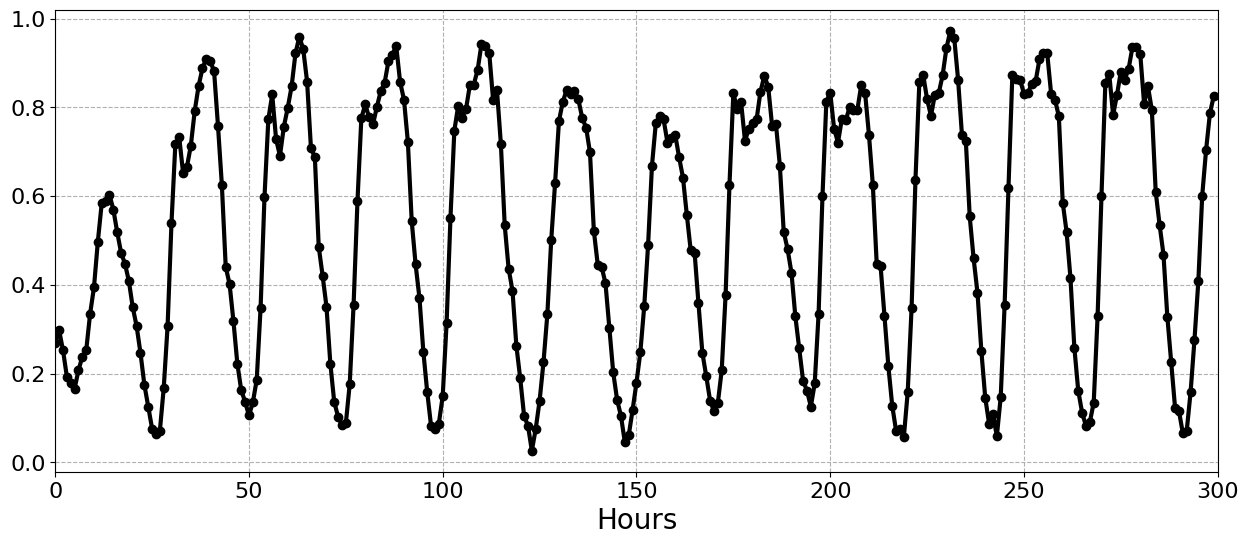

In [23]:
plt.figure(figsize=(15,6))
plt.plot(raw_data[:300],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,300)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Hours',fontsize=20)
# plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)

# Train/test data

In [24]:
dataX, dataY = build_window(data, history_length, forecast_length) # dataX array length 6, dataY is 24  
data.shape, dataX.shape, dataY.shape

((13980,), (13950, 1, 6), (13950, 24))

In [25]:
num_train_samples = int(0.8 * len(raw_data))
trainX, trainY = dataX[:num_train_samples,:,:], dataY[:num_train_samples,:]
valX,  valY    = dataX[num_train_samples:,:,:], dataY[num_train_samples:,:]
trainX.shape, trainY.shape, valX.shape,  valY.shape

((11184, 1, 6), (11184, 24), (2766, 1, 6), (2766, 24))

# DENSE 

In [26]:
# a plain vanilla dense neural network
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(16, activation="relu"))
model_dense.add(Dense(24))

In [27]:
model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")
history_dense = model_dense.fit(trainX, trainY, epochs=500, batch_size=32, validation_data = (valX, valY) )

Epoch 1/500
350/350 [==============================] - 1s 1ms/step - loss: 23405514.0000 - mae: 3798.7979 - val_loss: 11521038.0000 - val_mae: 2649.3110
Epoch 2/500
350/350 [==============================] - 0s 845us/step - loss: 9649900.0000 - mae: 2379.5818 - val_loss: 7906820.0000 - val_mae: 2136.7532
Epoch 3/500
350/350 [==============================] - 0s 914us/step - loss: 6860064.0000 - mae: 1951.3969 - val_loss: 6267634.5000 - val_mae: 1862.7958
Epoch 4/500
350/350 [==============================] - 0s 881us/step - loss: 5810863.5000 - mae: 1775.0061 - val_loss: 5707863.5000 - val_mae: 1778.1663
Epoch 5/500
350/350 [==============================] - 0s 844us/step - loss: 5427138.5000 - mae: 1712.4008 - val_loss: 5365354.5000 - val_mae: 1719.5996
Epoch 6/500
350/350 [==============================] - 0s 829us/step - loss: 5067638.0000 - mae: 1650.9812 - val_loss: 5046853.0000 - val_mae: 1660.9525
Epoch 7/500
350/350 [==============================] - 0s 820us/step - loss: 47645

In [28]:
# a plain vanilla dense neural network
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(dense_numunits, activation="relu"))
model_dense.add(Dense(forecast_length))

model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data = (valX, valY), verbose=0)

model_dense.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 6)                 0         
                                                                 
 dense_8 (Dense)             (None, 16)                112       
                                                                 
 dense_9 (Dense)             (None, 24)                408       
                                                                 
 flatten_3 (Flatten)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                400       
                                                                 
 dense_11 (Dense)            (None, 24)                408       
                                                                 
Total params: 1328 (5.19 KB)
Trainable params: 1328 (5

# SimpRNN

In [29]:
# a simple RNN model
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(16, input_shape=(1,6)))             
model_simprnn.add(Dense(24))

In [30]:
model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, epochs=500, batch_size=32, validation_data = (valX, valY) )

Epoch 1/500
350/350 [==============================] - 1s 1ms/step - loss: 60887744.0000 - mae: 7220.0459 - val_loss: 55048444.0000 - val_mae: 6805.7139
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 60801184.0000 - mae: 7214.0493 - val_loss: 54964228.0000 - val_mae: 6799.5142
Epoch 3/500
350/350 [==============================] - 0s 989us/step - loss: 60708904.0000 - mae: 7207.6416 - val_loss: 54875856.0000 - val_mae: 6793.0020
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 60615796.0000 - mae: 7201.1733 - val_loss: 54789700.0000 - val_mae: 6786.6602
Epoch 5/500
350/350 [==============================] - 0s 1ms/step - loss: 60526844.0000 - mae: 7195.0034 - val_loss: 54707264.0000 - val_mae: 6780.5850
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 60440044.0000 - mae: 7188.9634 - val_loss: 54626088.0000 - val_mae: 6774.5928
Epoch 7/500
350/350 [==============================] - 0s 1ms/step - loss: 60354

In [31]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(simplernn_numunits, input_shape=(1,history_length)))             
model_simprnn.add(Dense(forecast_length))

model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data = (valX, valY), verbose=0)

model_simprnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 16)                368       
                                                                 
 dense_13 (Dense)            (None, 24)                408       
                                                                 
Total params: 776 (3.03 KB)
Trainable params: 776 (3.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# LSTM

In [32]:
# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, 6)))
model_lstm.add(Dense(24))

In [33]:
model_lstm.compile(loss='mse', metrics=["mae"])

history = model_lstm.fit(trainX, trainY, epochs=500, batch_size=32, validation_data = (valX, valY) )

Epoch 1/500
350/350 [==============================] - 1s 2ms/step - loss: 60901396.0000 - mae: 7220.9756 - val_loss: 55078992.0000 - val_mae: 6807.9443
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 60856236.0000 - mae: 7217.8491 - val_loss: 55037044.0000 - val_mae: 6804.8647
Epoch 3/500
350/350 [==============================] - 0s 1ms/step - loss: 60808596.0000 - mae: 7214.5513 - val_loss: 54988660.0000 - val_mae: 6801.3081
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 60758984.0000 - mae: 7211.1089 - val_loss: 54943820.0000 - val_mae: 6798.0137
Epoch 5/500
350/350 [==============================] - 0s 1ms/step - loss: 60711540.0000 - mae: 7207.8247 - val_loss: 54899052.0000 - val_mae: 6794.7202
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 60664360.0000 - mae: 7204.5527 - val_loss: 54854532.0000 - val_mae: 6791.4438
Epoch 7/500
350/350 [==============================] - 0s 1ms/step - loss: 6061713

In [34]:
model_lstm = Sequential()
model_lstm.add(LSTM(lstm_numunits, input_shape=(1, history_length)))
model_lstm.add(Dense(forecast_length))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_lstm = model_lstm.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data = (valX, valY), verbose=0)

model_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1472      
                                                                 
 dense_15 (Dense)            (None, 24)                408       
                                                                 
Total params: 1880 (7.34 KB)
Trainable params: 1880 (7.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# PLOT

Text(0, 0.5, 'MSE')

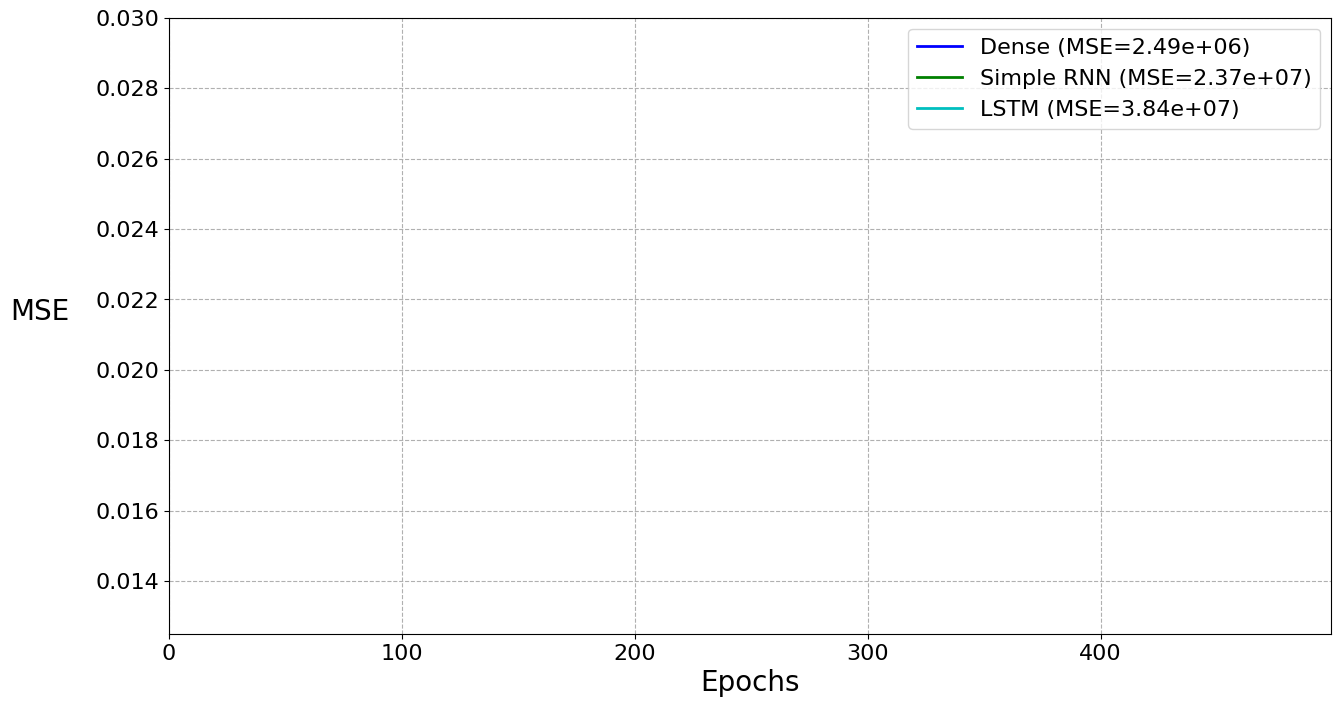

In [35]:
e = range(epochs)

mse_dense = np.mean(history_dense.history['val_loss'][-5:-1])
mse_simprnn = np.mean(history_simprnn.history['val_loss'][-5:-1])
mse_lstm = np.mean(history_lstm.history['val_loss'][-5:-1])


plt.figure(figsize=(15,8))
plt.plot(e,history_dense.history['loss'], 'b--', linewidth=2)
plt.plot(e,history_dense.history['val_loss'], 'b-', linewidth=2,label='Dense (MSE={:.2e})'.format(mse_dense))
plt.plot(e,history_simprnn.history['loss'], 'g--', linewidth=2)
plt.plot(e,history_simprnn.history['val_loss'], 'g-', linewidth=2,label='Simple RNN (MSE={:.2e})'.format(mse_simprnn))
plt.plot(e,history_lstm.history['loss'], 'c--', linewidth=2)
plt.plot(e,history_lstm.history['val_loss'], 'c-', linewidth=2, label='LSTM (MSE={:.2e})'.format(mse_lstm))
plt.xlim(0,epochs-1)
plt.ylim(0.0125,0.03)
plt.legend(fontsize=16)
plt.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)

# Animation

87/87 [==============================] - 0s 533us/step


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

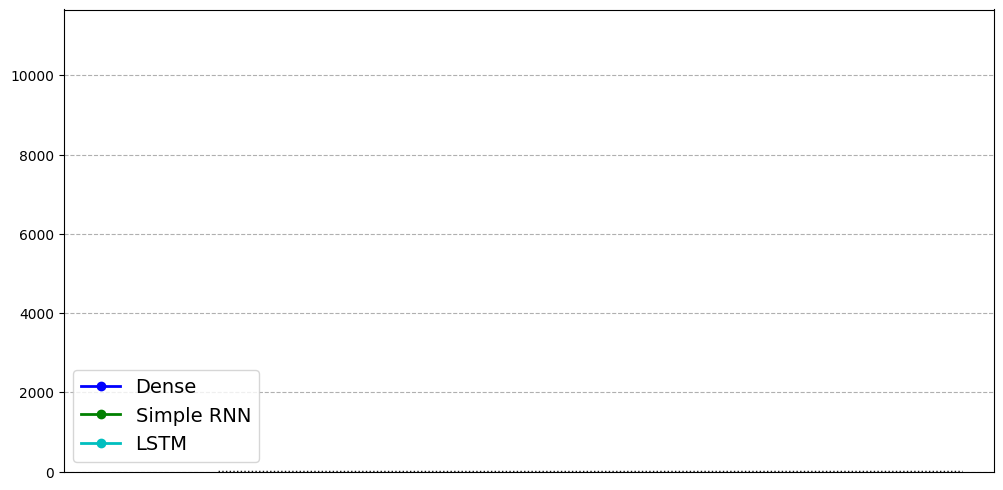

In [36]:
if doanim:
    
    tx0 = history_length-1 + np.arange(forecast_length+1)
    tx1 = np.arange(30)
    tx2 = np.arange(history_length)
    ty = history_length + np.arange(forecast_length)
    ind = 4

    ypred_lstm = scaler.inverse_transform(model_lstm.predict(valX))
    ypred_simprnn = scaler.inverse_transform(model_simprnn.predict(valX))
    ypred_dense = scaler.inverse_transform(model_dense.predict(valX))
    # raw_data_ = scaler.inverse_transform(raw_data)

    fig = plt.figure(figsize=(12,6)) 
    axis = plt.axes(xlim =(0, 30),ylim=(0,11662)) 

    line0, = axis.plot([], [],':', color=[.1,.1,.1], lw = 1) 
    line1, = axis.plot([], [],'ko-', lw = 3) 
    line4, = axis.plot([], [],'bo-', lw = 2, label='Dense') 
    line3, = axis.plot([], [],'go-', lw = 2, label='Simple RNN') 
    line2, = axis.plot([], [],'co-', lw = 2, label='LSTM') 
    plt.grid(linestyle='--')
    plt.legend(fontsize=14,loc='lower left')
    plt.xticks([])

    def init(): 
        line0.set_data([], [])
        line1.set_data([], [])
        line2.set_data([], [])
        line3.set_data([], [])
        line4.set_data([], [])
        return line0, line1, line2, line3, line4

    def animate(i):
        x = raw_data[i+num_train_samples+history_length-1:i+num_train_samples+history_length+forecast_length]
        line0.set_data(tx0,x)
        line1.set_data(tx2,scaler.inverse_transform(valX[i]))
        line2.set_data(ty,ypred_lstm[i])
        line3.set_data(ty,ypred_simprnn[i])
        line4.set_data(ty,ypred_dense[i])
        return line1, line2, line3, line4

    anim = FuncAnimation(fig, animate, init_func = init, frames = 2000, interval = 20, blit = True)

    anim.save('flow_pred.mp4', writer = 'ffmpeg', fps = 10)